# Project: High-Throughput Golomb-Rice Decoding via Parallelization
**By: Ruiwen**

This project implements a lossless image compressor using a predictive model and Golomb-Rice entropy coding. We also explore performance gains through parallelized decoding.

In [3]:
import time
import math
import os
import numpy as np
from PIL import Image
from bitarray import bitarray
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
def map_to_unsigned(n):
    """Maps a signed integer to an unsigned integer."""
    if n >= 0:
        return 2 * n
    else:
        return -2 * n - 1


def map_to_signed(n):
    """Maps an unsigned integer back to a signed integer."""
    if n % 2 == 0:
        return n // 2
    else:
        return -(n + 1) // 2


def rice_encode(residuals, m):
    """
    Encodes a list of residuals using Golomb-Rice coding.

    Args:
        residuals (list[int]): The prediction errors to encode.
        m (int): The Rice coding parameter (must be a power of 2).

    Returns:
        bitarray: The encoded bitstream.
    """
    if not (m > 0 and (m & (m - 1)) == 0):
        raise ValueError("m must be a power of 2.")

    bits = bitarray()
    k = int(math.log2(m))

    for r in residuals:
        # 1. Map signed residual to a non-negative integer
        n = map_to_unsigned(r)

        # 2. Calculate quotient and remainder
        quotient = n // m
        remainder = n % m

        # 3. Encode quotient in unary (q '1's followed by a '0')
        bits.extend("1" * quotient + "0")

        # 4. Encode remainder in binary with k bits
        remainder_bits = f"{remainder:0{k}b}"
        bits.extend(remainder_bits)

    return bits


def rice_decode(bits, m, num_residuals):
    """
    Decodes a Golomb-Rice bitstream back into residuals.

    Args:
        bits (bitarray): The bitstream to decode.
        m (int): The Rice coding parameter used for encoding.
        num_residuals (int): The expected number of residuals to decode.

    Returns:
        list[int]: The decoded signed residuals.
    """
    if not (m > 0 and (m & (m - 1)) == 0):
        raise ValueError("m must be a power of 2.")

    residuals = []
    k = int(math.log2(m))
    idx = 0

    while len(residuals) < num_residuals and idx < len(bits):
        # 1. Decode quotient from unary
        quotient = 0
        while bits[idx] == 1:
            quotient += 1
            idx += 1
        idx += 1  # Skip the '0' separator

        # 2. Decode remainder from binary
        if idx + k > len(bits):
            break  # Avoid index error on malformed stream
        remainder_bits = bits[idx : idx + k]
        remainder = int(remainder_bits.to01(), 2)
        idx += k

        # 3. Reconstruct the unsigned number and map back to signed
        n = quotient * m + remainder
        r = map_to_signed(n)
        residuals.append(r)

    return residuals


In [5]:
import golomb_rice
import predictor

def get_residuals(image_data):
    """
    Calculates prediction errors (residuals) for an image.
    Uses a simple predictor: predict current pixel = left pixel.
    """
    residuals = np.zeros_like(image_data, dtype=np.int16)
    # Predict first column as 0
    residuals[:, 0] = image_data[:, 0]
    # For other columns, residual = actual - predicted (left pixel)
    residuals[:, 1:] = image_data[:, 1:].astype(np.int16) - image_data[:, :-1].astype(
        np.int16
    )
    return residuals


def reconstruct_from_residuals(residuals):
    """
    Reconstructs the image from its residuals.
    This is the inverse of the prediction step.
    """
    reconstructed = np.zeros_like(residuals, dtype=np.uint8)
    # First column is the same as the residual
    reconstructed[:, 0] = residuals[:, 0].astype(np.uint8)
    # For other columns, actual = residual + predicted (left pixel)
    for col in range(1, reconstructed.shape[1]):
        reconstructed[:, col] = (residuals[:, col] + reconstructed[:, col - 1]).astype(
            np.uint8
        )
    return reconstructed


In [6]:
def compress_image(image_path, m, num_chunks):
    """
    Loads, processes, and compresses an image into independent chunks.
    Also saves a visual representation of the residuals.
    """
    print(f"Compressing '{image_path}'...")
    # Load image and convert to grayscale numpy array
    try:
        img = Image.open(image_path).convert("L")
        image_data = np.array(img)
    except FileNotFoundError:
        print(f"Error: Image file not found at '{image_path}'")
        return None, None

    # Get prediction errors
    residuals = predictor.get_residuals(image_data)

    # To make residuals viewable, we map them to the 0-255 range.
    # A residual of 0 (perfect prediction) will be mapped to mid-gray (128).
    residuals_visual = residuals.astype(np.int16) + 128
    # Clip values to ensure they are within the valid 0-255 range for an image
    residuals_visual = np.clip(residuals_visual, 0, 255).astype(np.uint8)

    # Get the base name of the input file to create descriptive output names
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    residuals_path = f"results/{base_name}_residuals.png"
    save_image(residuals_visual, residuals_path)

    # Split residuals into chunks for parallel processing
    chunk_data = np.array_split(residuals, num_chunks)

    # Encode each chunk independently
    encoded_chunks = [
        golomb_rice.rice_encode(chunk.flatten(), m) for chunk in chunk_data
    ]

    # The compressed object contains all info needed for decompression
    compressed_object = {
        "original_shape": image_data.shape,
        "m": m,
        "num_residuals_per_chunk": [len(chunk.flatten()) for chunk in chunk_data],
        "chunks": encoded_chunks,
    }

    return compressed_object, image_data


def decompress_serial(compressed_obj):
    """Decompresses chunks one by one in a single thread."""
    m = compressed_obj["m"]
    decoded_residuals = []

    for i, chunk_bits in enumerate(compressed_obj["chunks"]):
        num_residuals = compressed_obj["num_residuals_per_chunk"][i]
        decoded_residuals.extend(golomb_rice.rice_decode(chunk_bits, m, num_residuals))

    residuals_arr = np.array(decoded_residuals).reshape(
        compressed_obj["original_shape"]
    )
    return predictor.reconstruct_from_residuals(residuals_arr)


def decompress_parallel(compressed_obj):
    """Decompresses chunks in parallel using a thread pool."""
    m = compressed_obj["m"]
    chunks = compressed_obj["chunks"]
    num_residuals_list = compressed_obj["num_residuals_per_chunk"]

    # Decode function for a single chunk
    def decode_worker(i):
        return golomb_rice.rice_decode(chunks[i], m, num_residuals_list[i])

    # Use a thread pool to run workers in parallel
    with ThreadPoolExecutor() as executor:
        decoded_chunks = list(executor.map(decode_worker, range(len(chunks))))

    # Combine the results
    decoded_residuals = [item for sublist in decoded_chunks for item in sublist]
    residuals_arr = np.array(decoded_residuals).reshape(
        compressed_obj["original_shape"]
    )
    return predictor.reconstruct_from_residuals(residuals_arr)


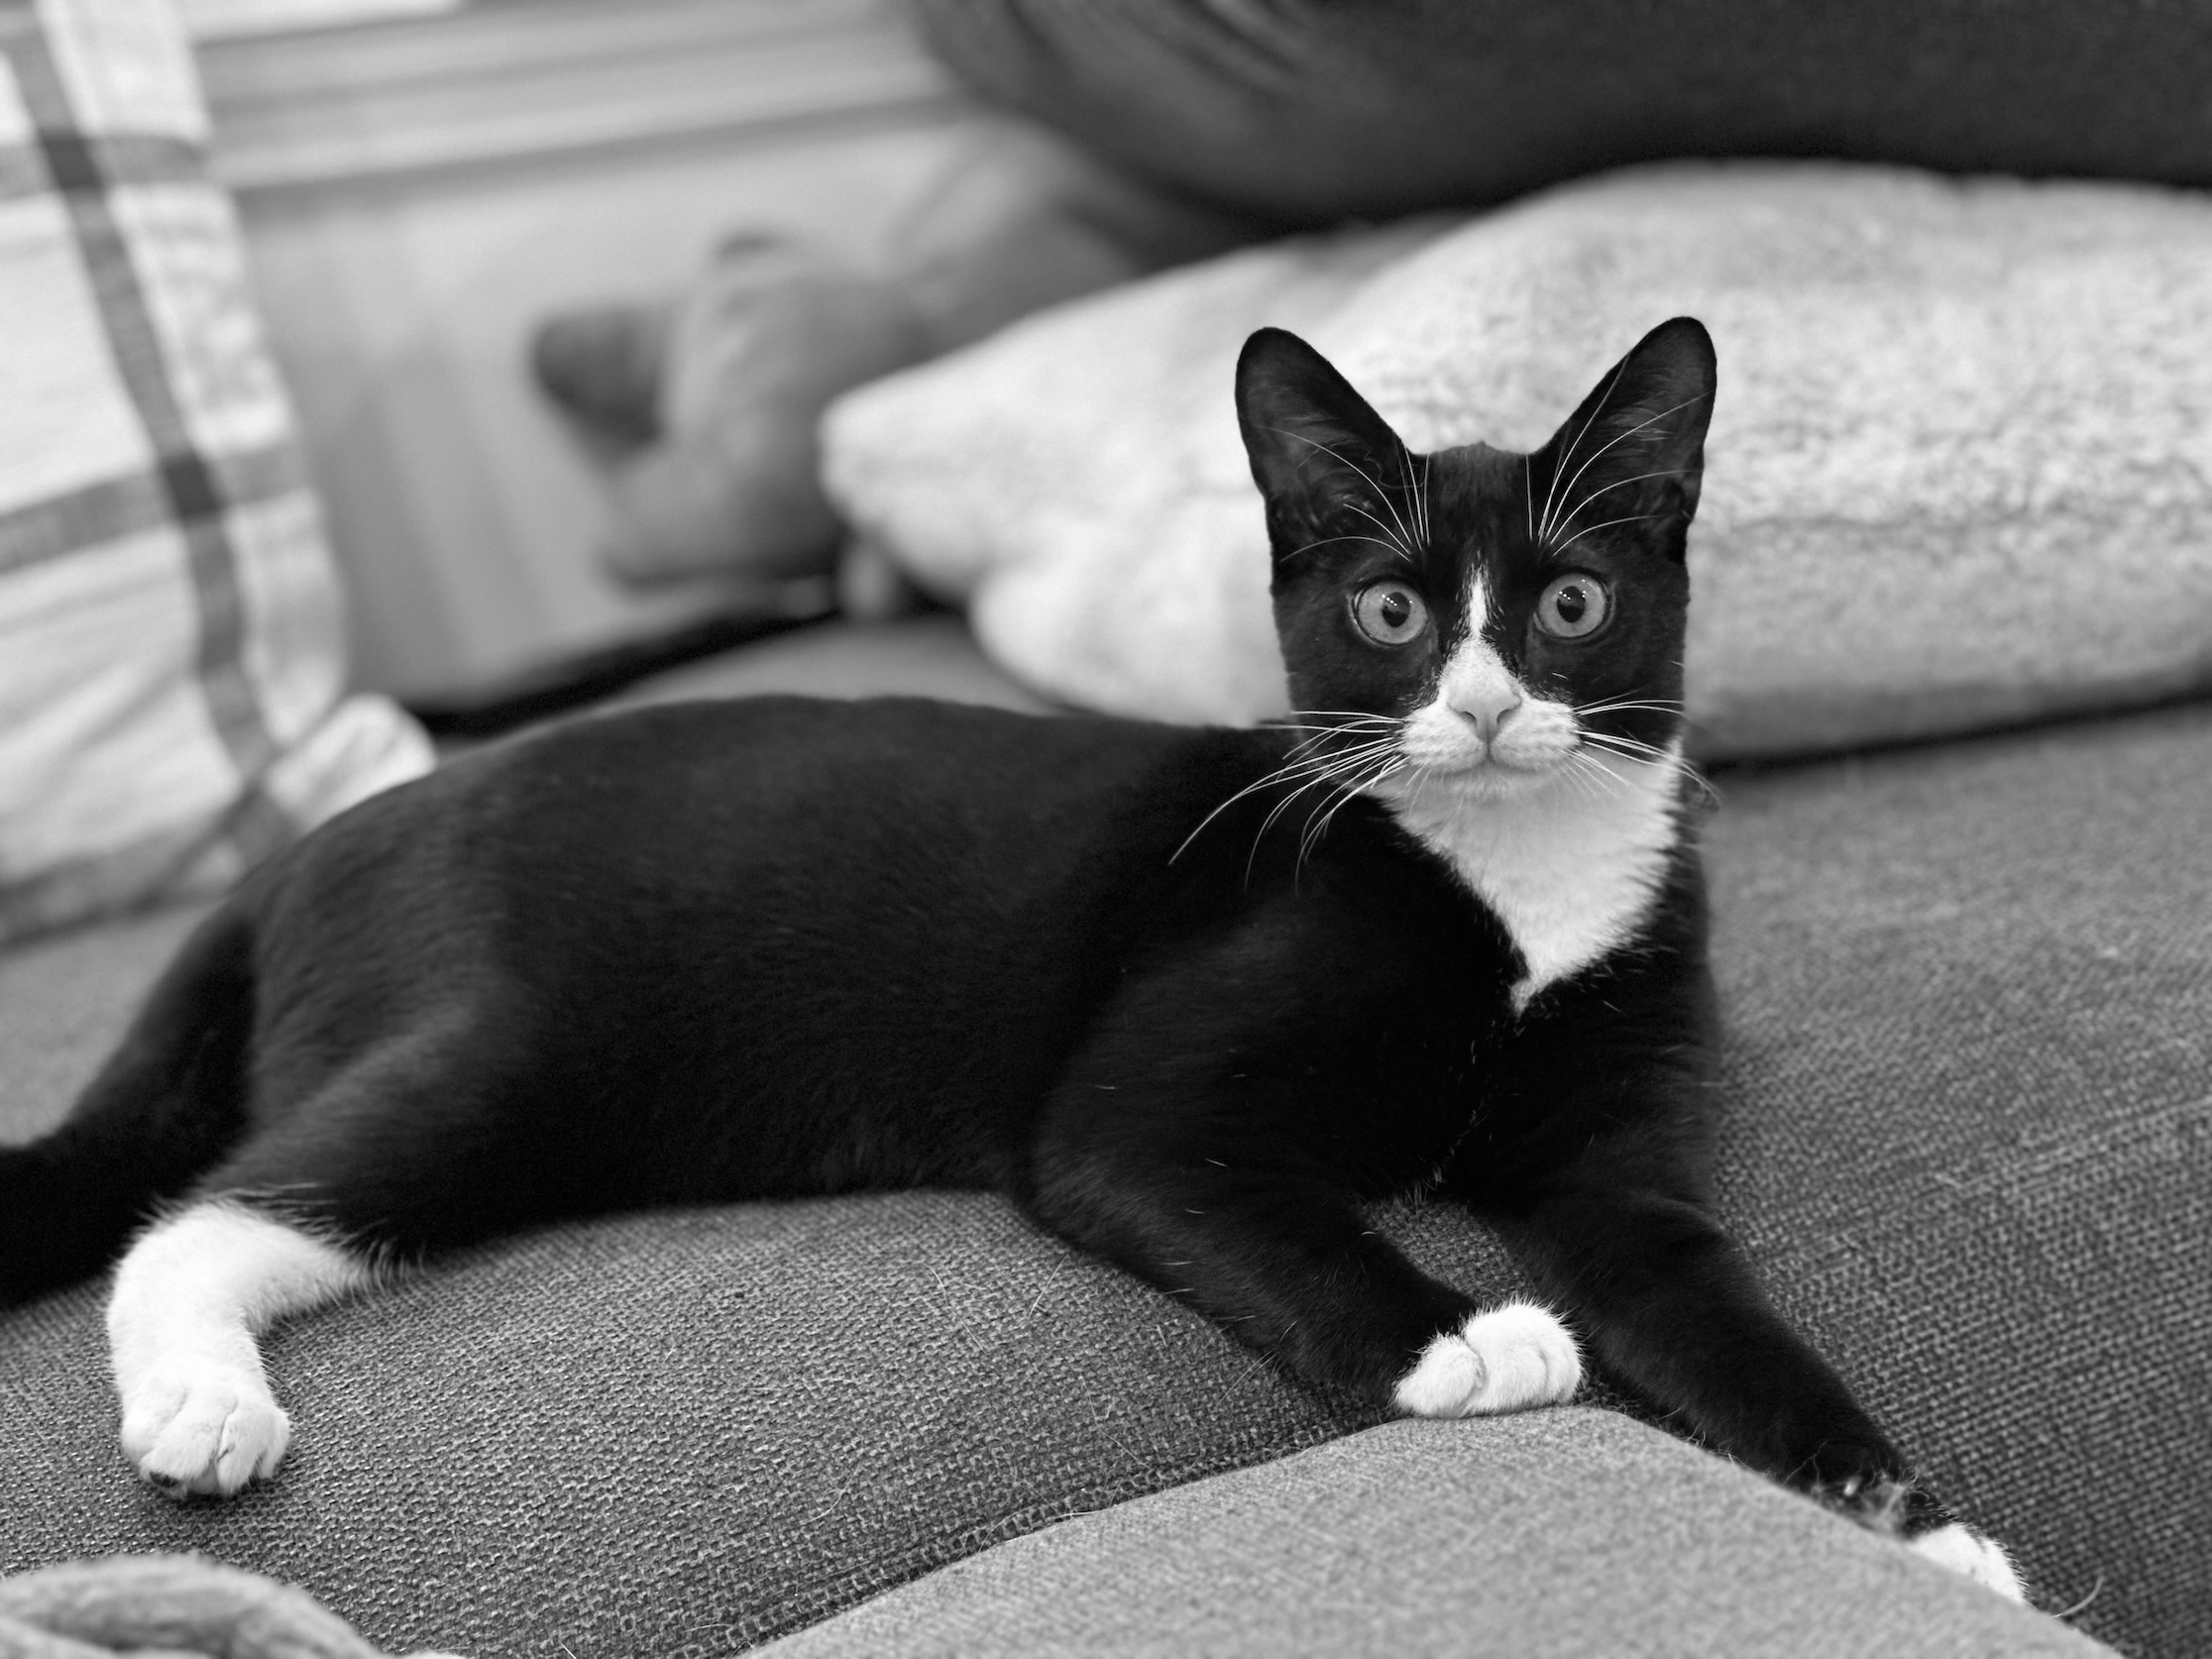

In [7]:
IMAGE_PATH = "assets/coconut.jpeg"
# To display the image directly in the notebook:
original_img = Image.open(IMAGE_PATH).convert("L")
display(original_img)
original_image_data = np.array(original_img)


Residuals Image (Gray = Good Prediction, Edges = Poor Prediction)


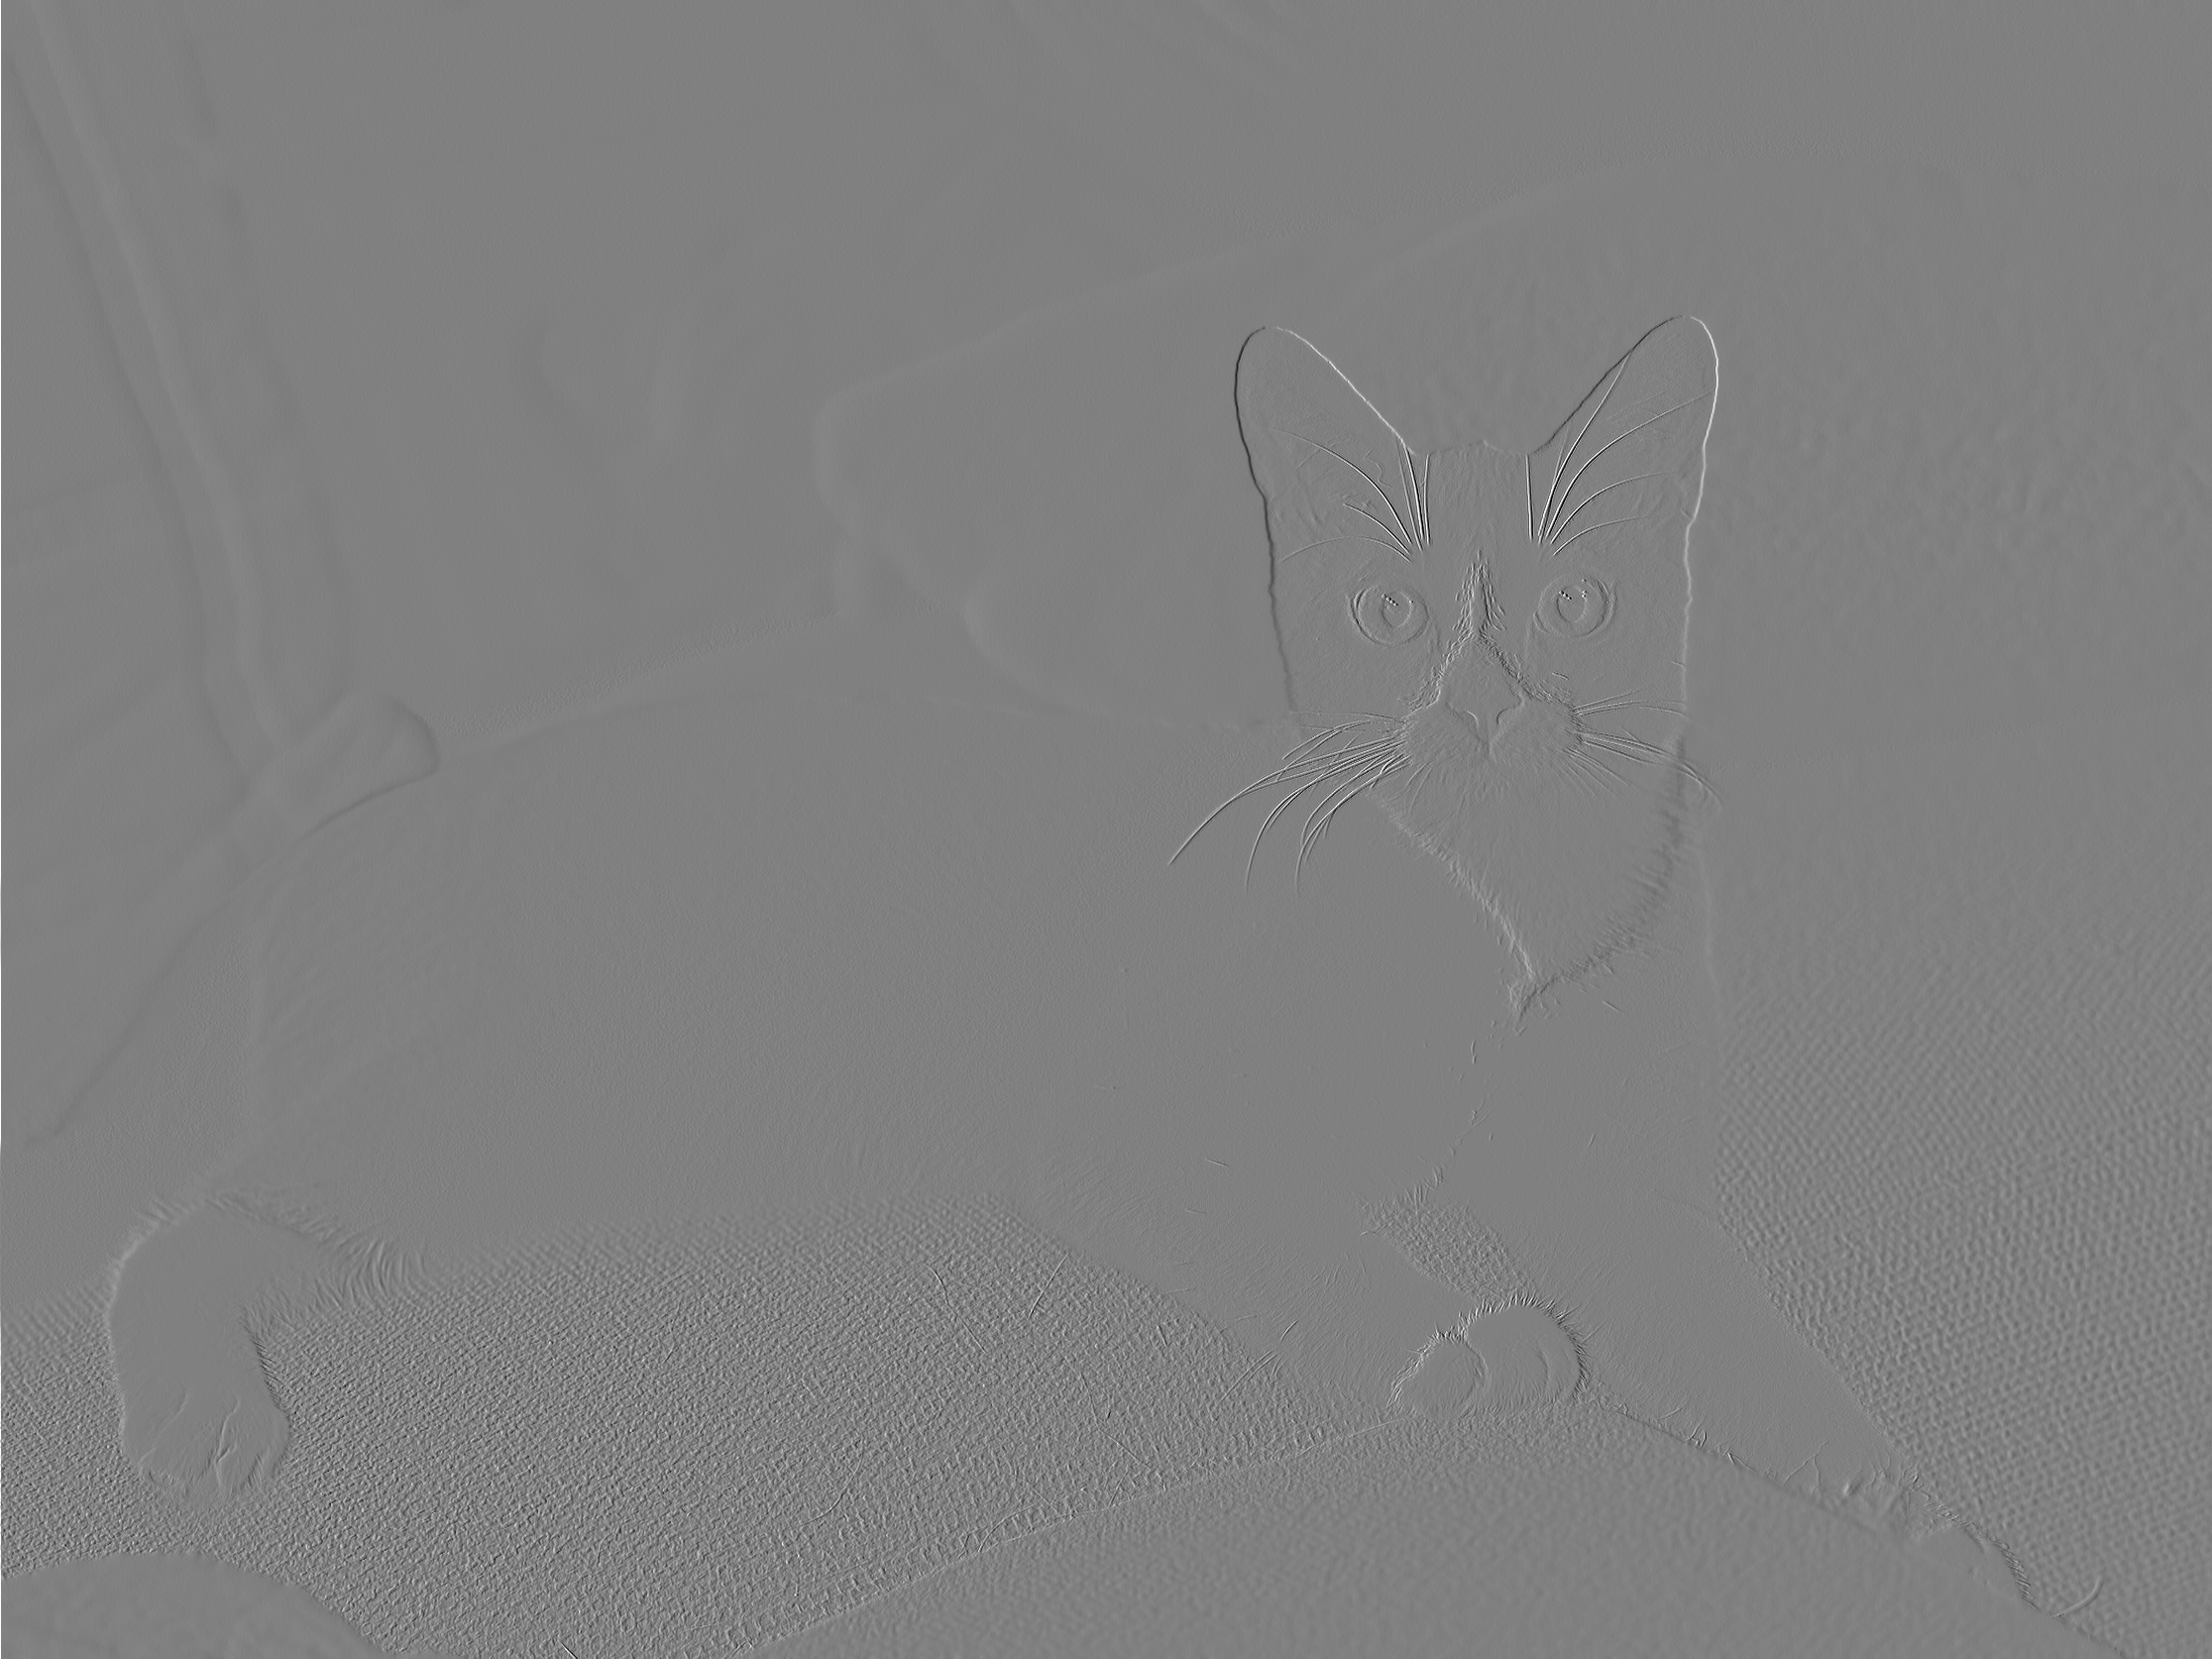

In [8]:
RICE_PARAMETER_M = 16
NUM_CHUNKS = 8

# Compress...
residuals = predictor.get_residuals(original_image_data)

# Visualize and display residuals
residuals_visual = np.clip(residuals.astype(np.int16) + 128, 0, 255).astype(np.uint8)
residuals_img = Image.fromarray(residuals_visual)
print("Residuals Image (Gray = Good Prediction, Edges = Poor Prediction)")
display(residuals_img)
